In [1]:
from statsmodels.tsa.statespace.varmax import VARMAX

import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

We have app data that for each user pairs reported app metrics and app name:

In [2]:
appDf = pd.read_csv("app.data", names=["user", "date", "app", "metric"])
appDf['date'] = pd.to_datetime(appDf['date'])
appDf.info()
print(appDf.user.unique(), appDf.app.unique())
appDf.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 4 columns):
user      208 non-null object
date      208 non-null datetime64[ns]
app       208 non-null object
metric    208 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.6+ KB
['user_3' 'user_1' 'user_2'] [' app_1' ' app_2' ' app_3']


,user,date,app,metric
0,user_3,2017-08-28 00:05:06,app_1,0.10
1,user_1,2017-08-28 04:15:36,app_2,0.02
2,user_1,2017-08-29 04:57:15,app_2,0.04
3,user_1,2017-08-29 05:34:10,app_1,0.01
4,user_3,2017-08-29 07:16:00,app_1,0.20


We have location data that uses keywords for location and indicates a change of location:

In [3]:
locationDf = pd.read_csv("location.data", names=["user", "date", "location"])
locationDf['date'] = pd.to_datetime(locationDf['date'])

cross_l = pd.crosstab([locationDf.date, locationDf.user], locationDf.location)

cross_l.head(3)

location                     bar   girlfriends   grocers   home   lunch  \
date                user                                                  
2017-08-28 00:00:01 user_2     0             0         0      1       0   
                    user_3     0             0         0      1       0   
2017-08-29 00:00:01 user_1     0             0         0      1       0   

location                     park   relatives   work  
date                user                              
2017-08-28 00:00:01 user_2      0           0      0  
                    user_3      0           0      0  
2017-08-29 00:00:01 user_1      0           0      0

Location data includes seasonality at actual seasonal levels (summer, winter), as well as weekday/weekend behavior. Here this is demonstrated with cumsum:

'User/Locations'

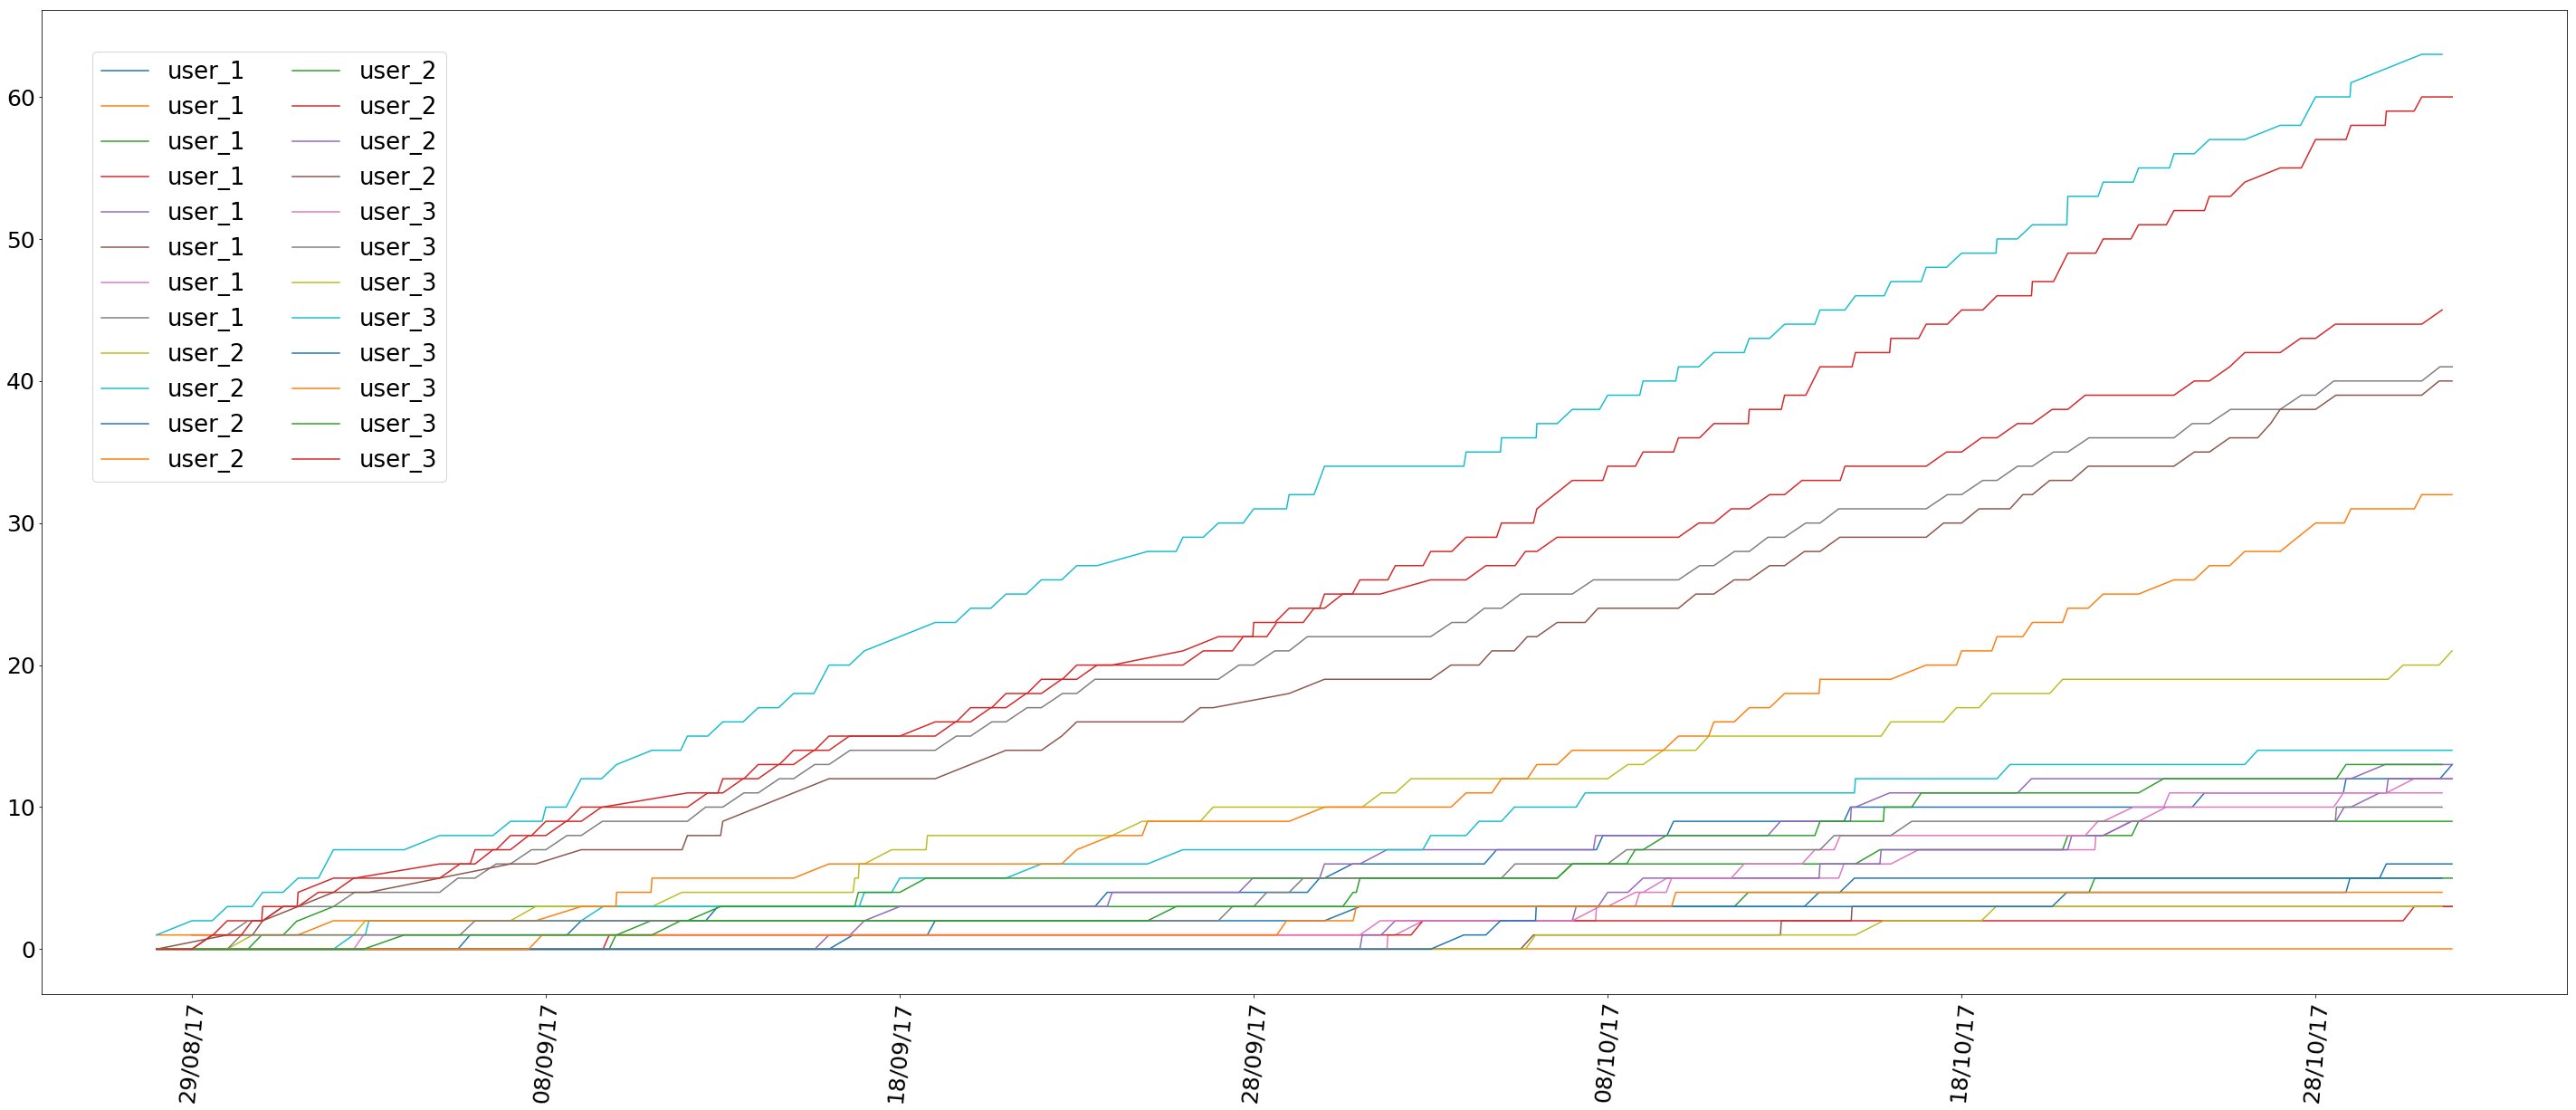

In [4]:
cross = cross_l.copy()

l2 = cross.groupby(['user']).cumsum().copy()
l2.reset_index(inplace=True)

plotaxis = plt.figure(figsize=(50,20)).gca()
for key, grp in l2.groupby(['user']):
    my_ts = [ts.to_julian_date() - 1721424.5 for ts in grp['date']]
    plt.plot(my_ts, grp.drop('user', axis=1).drop('date', axis=1), label=key)

plotaxis.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%d/%m/%y')
)
xlabels = plotaxis.get_xticklabels()
plt.setp(xlabels, rotation=85, fontsize=25)
ylabels = plotaxis.get_yticklabels()
plt.setp(ylabels, fontsize=25)

plt.legend(bbox_to_anchor=(.02, 0.52, 1., .102), loc=3,
           ncol=2, borderaxespad=0., prop={'size': 26})    

#l3 = l2[l2['user'] == 'user_1'].copy()
#l3['month']=l3['date'].dt.month
#grouped = l3.groupby(l3['month'])
#
#for m in grouped.groups.keys():
#    print(l3[l3['month'] == m].tail(1))
#l2.groupby(['user']).sum()

'User/Locations'

The some metric data is set to have positive or negative correlation in terms of growth, to location data. Excluding seasonality, the metric data should trend upwards:

'Users/Apps'

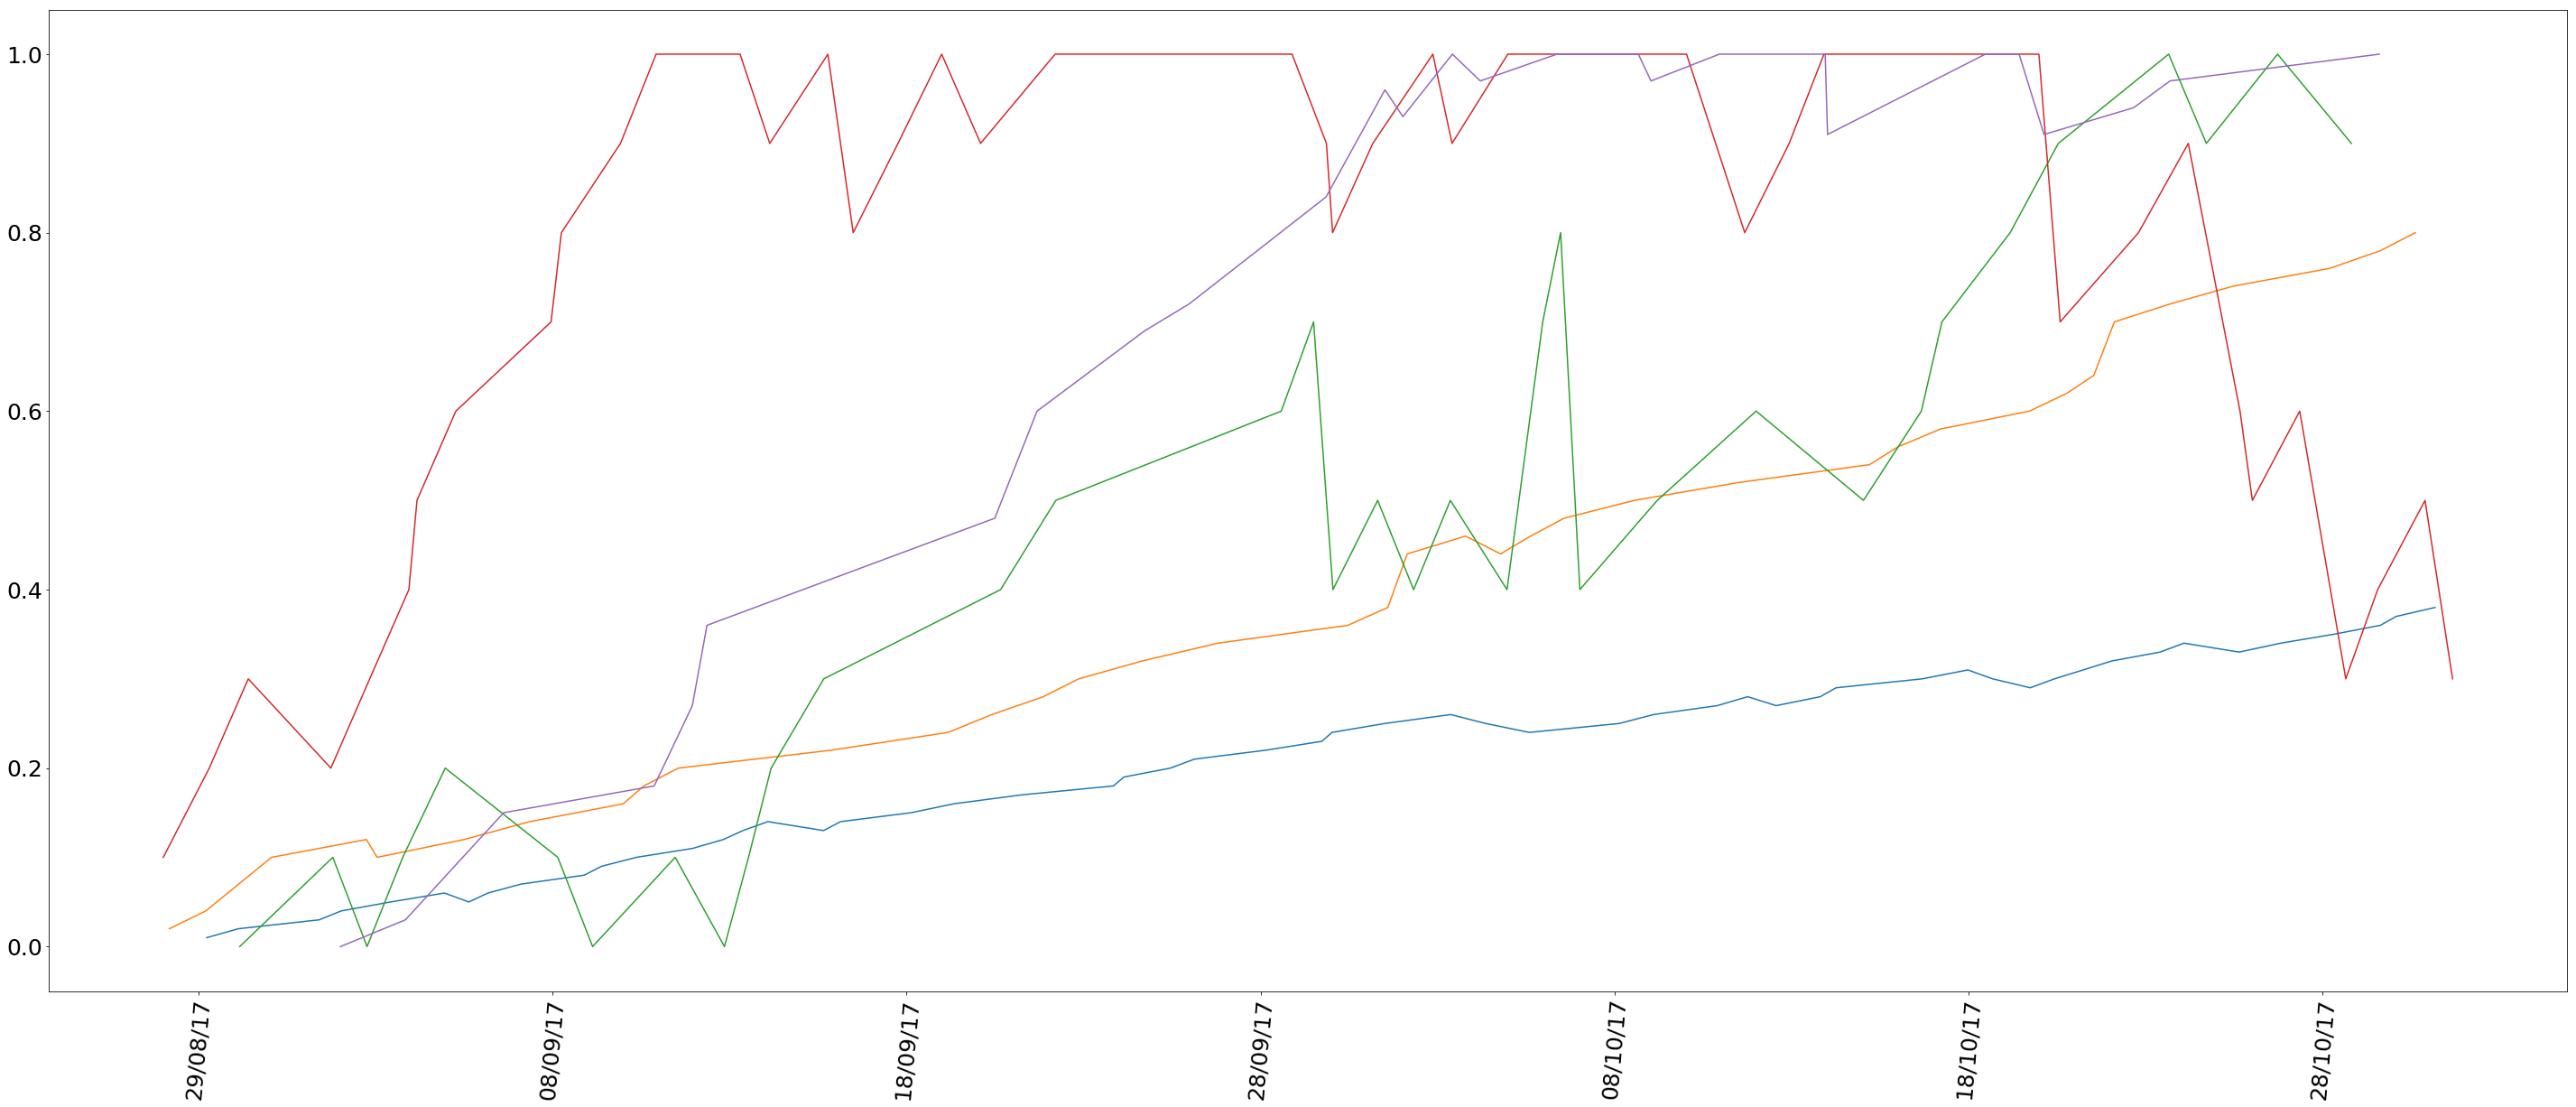

In [5]:
#appDf.groupby(['user', 'app']).plot(x="date", y="metric", subplots=True)

plotaxis = plt.figure(figsize=(50,20)).gca()
for key, grp in appDf.groupby(['user', 'app']):
    my_ts = [ts.to_julian_date() - 1721424.5 for ts in grp['date']]
    plt.plot(my_ts, grp['metric'], label='%s@%s' % ("metric", key))

plotaxis.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%d/%m/%y')
)
xlabels = plotaxis.get_xticklabels()
plt.setp(xlabels, rotation=85, fontsize=25)
ylabels = plotaxis.get_yticklabels()
plt.setp(ylabels, fontsize=25)
'Users/Apps'

In the next plot, we can see in fine detail user_3's metric trend and location data. Looking at the very beginning at increased zoom, you might notice a visual correlation between the first few gaps and the faster-rising app data. Frequency of use should also positively correlate.

True

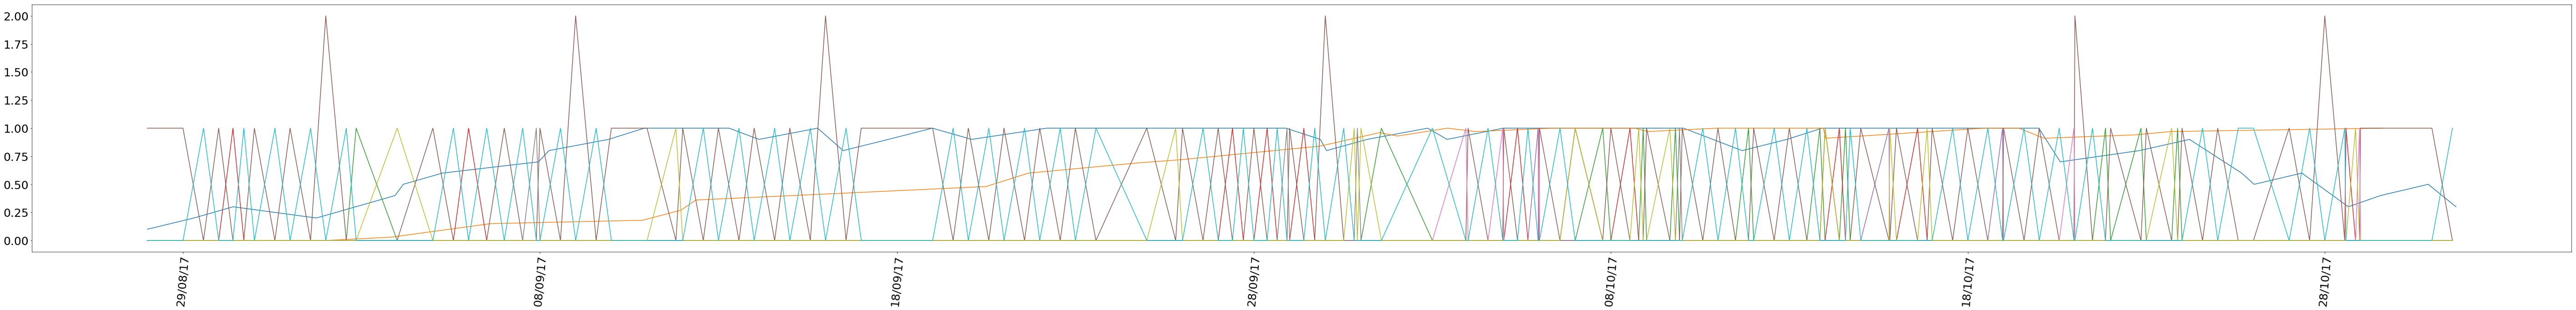

In [6]:
cross.reset_index(inplace=True)

u1_l = cross[cross['user'] == 'user_3']

u1_a = appDf[appDf['user'] == 'user_3']

u1_a1 = u1_a[u1_a['app'] == ' app_1']
u1_a2 = u1_a[u1_a['app'] == ' app_2']

plotaxis = plt.figure(figsize=(100,10)).gca()

for key, grp in u1_a.groupby(['app']):
    my_ts = [ts.to_julian_date() - 1721424.5 for ts in grp['date']]
    plt.plot(my_ts, grp['metric'], label='%s@%s' % ("metric", key))    

for key, grp in u1_l.groupby(['user']):
    my_ts = [ts.to_julian_date() - 1721424.5 for ts in grp['date']]
    plt.plot(my_ts, grp.drop('user', axis=1).drop('date', axis=1), label=key)
    
plotaxis.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%d/%m/%y')
)
xlabels = plotaxis.get_xticklabels()
plt.setp(xlabels, rotation=85, fontsize=25)
ylabels = plotaxis.get_yticklabels()
plt.setp(ylabels, fontsize=25)
True

We want to produce classical machine learning/statistical modeling as a baseline to justify RNN approaches. We will follow this strategy in preparation of an ARIMA model:

0. resample to 15m intervals (data set would be insufficient to form the ARIMA model as the majority are errant occluding/masking/hiding the underlying predictive signal/model/equation/weighted average necessary to provide the baseline, so we will interpolate at the end)
1. fill rows in both set by date, so the data sets can be combined.
2. convert metric data to metric values per app: first creating a column for each app.
3. get column categories for location
4. divide data into per user charts.
5. combine app/metric and location data.
6. interpolate metric data per user to get curves we can predict from.

In [71]:
locDf = locationDf.copy()
locDf.set_index('date', inplace=True)

locDfs = {}
for user, user_loc_dc in locDf.groupby('user'):
    locDfs[user] = user_loc_dc.resample('15T').agg('max').bfill()
    
aDf = appDf.copy()
aDf.set_index('date', inplace=True)

userLocAppDfs = {}
for user, a2_df in aDf.groupby('user'):
    userDf = a2_df.resample('15T').agg('max')
                
    userDf.reset_index(inplace=True)
    userDf = pd.crosstab(index=userDf['date'], columns=userDf['app'], values=userDf['metric'], aggfunc=np.mean).fillna(np.nan, downcast='infer')

    userDf['user'] = user
        
    userDf.reset_index(inplace=True)
    userDf.set_index('date', inplace=True)

    userLocAppDfs[user] = userDf.resample('15T').agg('max')
            
    loDf = locDfs[user]
    loDf.reset_index(inplace=True)
    loDf = pd.crosstab([loDf.date, loDf.user], loDf.location)
    loDf.reset_index(inplace=True)

    loDf.set_index('date', inplace=True)
    loDf.drop('user', axis=1, inplace=True)
    
    userLocAppDfs[user] = userLocAppDfs[user].join(loDf, how='outer')
    userLocAppDfs[user] = userLocAppDfs[user].resample('15T').agg('max')
    userLocAppDfs[user]['user'].fillna(user, inplace=True)
    
    for loc in locationDf[locationDf['user'] == user].location.unique():
        userLocAppDfs[user][loc] = userLocAppDfs[user][loc].replace(np.nan, 0)
            
    for app in a2_df['app'].unique():
        #print(userLocAppDfs[user][app].head(10))
        #userLocAppDfs[user][app].fillna(value=0, inplace=True)
        #userLocAppDfs[user][app].replace(0.0, np.nan, inplace=True)

        userLocAppDfs[user][app].interpolate(method='linear', limit_area='inside', inplace=True)       
        userLocAppDfs[user][app].fillna(value=0, inplace=True)
        
#userLocAppDfs['user_1'].tail(5)

At this point, we have our data set per user. Here's what one user's data looks like:

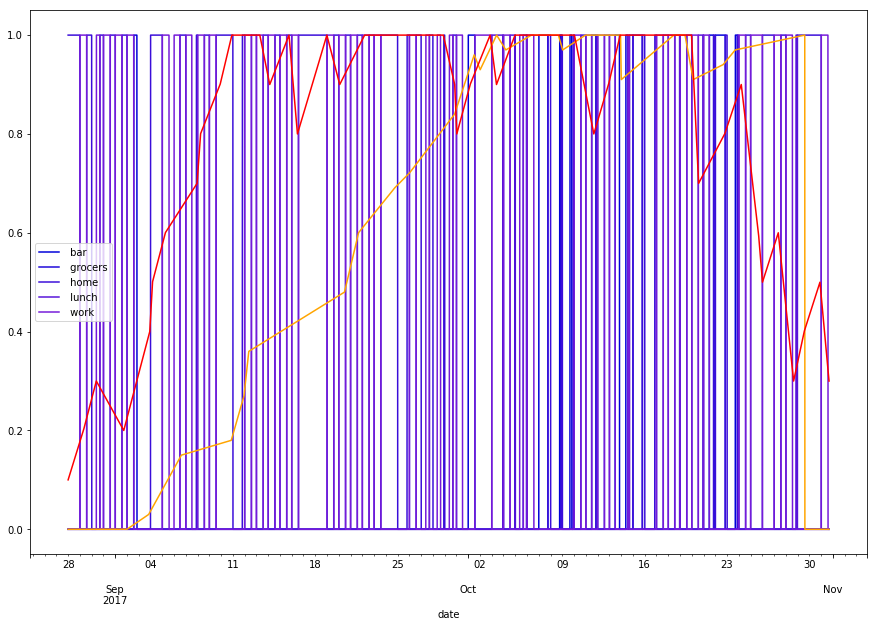

In [72]:
u1 = userLocAppDfs['user_3'].copy()
# https://stackoverflow.com/questions/11927715/how-to-give-a-pandas-matplotlib-bar-graph-custom-colors
locations = [(x/8.75, x/40.0, 0.85) for x in range(5)] # color grad

u1[[' bar', ' grocers', ' home', ' lunch', ' work']].plot(color=locations, figsize=(15,10))

u1[' app_3'].plot(color='orange')
u1[' app_1'].plot(color='r')
